# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
import tensorflow as tf
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import copy
import imutils
import imageio
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.mobilenet import preprocess_input

### Change directory

In [3]:
from google.colab import drive
drive.mount('/gdrive')
codepath = '/gdrive/My Drive/ACV-Lab'
import os
os.chdir(codepath)
!pwd
!ls -l

Mounted at /gdrive
/gdrive/My Drive/ACV-Lab
total 25983
drwx------ 2 root root     4096 Sep 12 05:16  images
-rw------- 1 root root 26574193 Sep 12 04:42  images_racoon.rar
-rw------- 1 root root    19327 Sep 13 04:51 'R9 - ACV - Internal_Lab_Questions.ipynb'
-rw------- 1 root root     7913 Sep 12 04:42  train_labels.csv
-rw------- 1 root root      151 Sep 12 05:03  train_labels.gsheet


### Load the training data from train.csv file

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [5]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [6]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [7]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height


In [8]:
print(paths)

['raccoon-17.jpg', 'raccoon-11.jpg', 'raccoon-63.jpg', 'raccoon-63.jpg', 'raccoon-60.jpg', 'raccoon-69.jpg', 'raccoon-180.jpg', 'raccoon-200.jpg', 'raccoon-141.jpg', 'raccoon-19.jpg', 'raccoon-84.jpg', 'raccoon-124.jpg', 'raccoon-182.jpg', 'raccoon-111.jpg', 'raccoon-91.jpg', 'raccoon-79.jpg', 'raccoon-93.jpg', 'raccoon-20.jpg', 'raccoon-42.jpg', 'raccoon-139.jpg', 'raccoon-58.jpg', 'raccoon-71.jpg', 'raccoon-183.jpg', 'raccoon-1.jpg', 'raccoon-169.jpg', 'raccoon-82.jpg', 'raccoon-4.jpg', 'raccoon-101.jpg', 'raccoon-10.jpg', 'raccoon-166.jpg', 'raccoon-184.jpg', 'raccoon-38.jpg', 'raccoon-120.jpg', 'raccoon-142.jpg', 'raccoon-149.jpg', 'raccoon-51.jpg', 'raccoon-43.jpg', 'raccoon-123.jpg', 'raccoon-66.jpg', 'raccoon-9.jpg', 'raccoon-178.jpg', 'raccoon-47.jpg', 'raccoon-167.jpg', 'raccoon-54.jpg', 'raccoon-77.jpg', 'raccoon-155.jpg', 'raccoon-89.jpg', 'raccoon-153.jpg', 'raccoon-179.jpg', 'raccoon-115.jpg', 'raccoon-64.jpg', 'raccoon-56.jpg', 'raccoon-44.jpg', 'raccoon-39.jpg', 'raccoon

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [22]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [23]:
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, fil in enumerate(paths):
    #print(i, fil)
    img = Image.open('images/images/' + fil)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Conv2D, Reshape 

In [25]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)


17227776/17225924 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [39]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [40]:
from tensorflow.keras.backend import epsilon

In [41]:
myModel.compile(loss="mse", optimizer="adam", metrics=[IoU]) 
myModel.fit(batch_images, coords, epochs=30,
                    batch_size = 32,                                      
                    workers=7,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=1) 


Epoch 1/30
6/6 [==============================] - 2s 259ms/step - loss: 78.8424 - IoU: 0.7914
Epoch 2/30
6/6 [==============================] - 2s 267ms/step - loss: 63.8234 - IoU: 0.8228
Epoch 3/30
6/6 [==============================] - 2s 259ms/step - loss: 58.9302 - IoU: 0.8256
Epoch 4/30
6/6 [==============================] - 2s 260ms/step - loss: 56.8982 - IoU: 0.8358
Epoch 5/30
6/6 [==============================] - 2s 257ms/step - loss: 57.5330 - IoU: 0.8619
Epoch 6/30
6/6 [==============================] - 2s 257ms/step - loss: 54.5874 - IoU: 0.8623
Epoch 7/30
6/6 [==============================] - 2s 260ms/step - loss: 57.4856 - IoU: 0.8253
Epoch 8/30
6/6 [==============================] - 2s 254ms/step - loss: 57.0904 - IoU: 0.8398
Epoch 9/30
6/6 [==============================] - 2s 255ms/step - loss: 54.4555 - IoU: 0.8604
Epoch 10/30
6/6 [==============================] - 2s 257ms/step - loss: 54.0023 - IoU: 0.8611
Epoch 11/30
6/6 [==============================] - 2s 257ms

### Pick a test image from the given data

In [42]:
test_img = '/gdrive/My Drive/ACV-Lab/images/raccoon-1.jpg'
unscaled = cv2.imread(test_img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [51]:
image_height, image_width, chnl = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [52]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

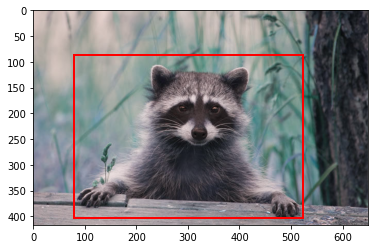

In [53]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()